In [49]:
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import copy

import sys
sys.path.append("/")
import data_helpers

In [50]:
tires = ["r25b_16x7-5_10x7","r25b_16x7-5_10x8","r25b_16x6-0_10x6","r25b_16x6-0_10x7",
        "lc10_16x7-5_10x8","lc10_16x7-5_10x7","lc10_16x6-0_10x6","lc10_16x6-0_10x7"]

sweeps = ["initial_default", "post_default"]
tire_coeffs = {}
for tire in tires:
    tire_coeffs[tire] = {sweep:{"lateral_mus":[], "long_mus":[], "long_norms":[], "lat_norms":[]} for sweep in sweeps}

camber = 0 # default camber
pressure = 12* 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
long_slip_angle = 0 # default slip angle for long
SA_cutoff = 10 # degrees, where slip occurs
SR_cutoff = 0.1 # %, where slip occurs

#load_lateral = np.array([-250, -200, -150, -100, -50]) / 0.224809
#load_long = np.array([-250, -200, -150, -50]) / 0.224809

# metric is something such as "SL" or "SA"
# output is something such as "NFX" or "NFY"
# lower is the absolute value lower bound of the metric
def get_normal_mus(df, normal_loads, lower, metric, output):
    return_mus = []
    #print(normal_loads)
    for x in normal_loads:
        load_df = df[(df["load"] == x) & ((df[metric] < -1*lower) | (df[metric] > lower))]
        return_mus.append(load_df[output].abs().mean()*2/3)
    return return_mus

In [51]:
### LATERAL CALCS ###
for tire in tires:
    try:
        initial = data_helpers.import_data(sio.loadmat("tire_data/processed_data/cornering_hoosier_{0}_run1.mat".format(tire)))
    except:
        # data hasnt been filtered yet (or doesnt exist)
        print("data hasn't been filtered yet", tire)
        continue
    try:
        post = data_helpers.import_data(sio.loadmat("tire_data/processed_data/cornering_hoosier_{0}_run2.mat".format(tire)))
    except:
        post = None

    print("Processed tire correctly:",tire)

    df = initial
    initial_df = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber))]
    initial_mus = get_normal_mus(initial_df, initial_df["load"].unique(), SA_cutoff, "SA", "NFY")
    tire_coeffs[tire]["initial_default"]["lateral_mus"] = initial_mus
    tire_coeffs[tire]["initial_default"]["lat_norms"] = initial_df["load"].unique()

    # find if there is an post sweep
    if post is not None:
        df = post
        post_df = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber))]
        post_mus = get_normal_mus(initial_df, post_df["load"].unique(), SA_cutoff, "SA", "NFY")
        tire_coeffs[tire]["post_default"]["lateral_mus"] = post_mus
        tire_coeffs[tire]["post_default"]["lat_norms"] = post_df["load"].unique()

Processed tire correctly: r25b_16x7-5_10x7
Processed tire correctly: r25b_16x7-5_10x8
Processed tire correctly: r25b_16x6-0_10x6
Processed tire correctly: r25b_16x6-0_10x7


Processed tire correctly: lc10_16x7-5_10x8
Processed tire correctly: lc10_16x7-5_10x7
Processed tire correctly: lc10_16x6-0_10x6
Processed tire correctly: lc10_16x6-0_10x7


In [52]:
### LONG CALCS ###
for tire in tires:
    try:
        initial = data_helpers.import_data(sio.loadmat("tire_data/processed_data/braking_hoosier_{0}_run1.mat".format(tire)))
    except:
        try:
            initial = data_helpers.import_data(sio.loadmat("tire_data/processed_data/braking_hoosier_{0}_fabricated.mat".format(tire)))
        except:
            # data hasnt been filtered yet (or doesnt exist)
            continue
    try:
        post = data_helpers.import_data(sio.loadmat("tire_data/processed_data/braking_hoosier_{0}_run2.mat".format(tire)))
    except:
        post = None

    print(tire)

    df = initial
    initial_df = df[((df["slip"] == long_slip_angle) & (df["pressure"] == pressure) & (df["camber"] == camber))]
    initial_mus = get_normal_mus(initial_df, initial_df["load"].unique(), SR_cutoff, "SL", "NFX")
    tire_coeffs[tire]["initial_default"]["long_mus"] = initial_mus
    tire_coeffs[tire]["initial_default"]["long_norms"] = initial_df["load"].unique()

    # find if there is an post sweep
    if post is not None:
        df = post
        post_df = df[((df["slip"] == long_slip_angle) & (df["pressure"] == pressure) & (df["camber"] == camber))]
        post_mus = get_normal_mus(initial_df, post_df["load"].unique(), SR_cutoff, "SL", "NFX")
        tire_coeffs[tire]["post_default"]["long_mus"] = post_mus
        tire_coeffs[tire]["post_default"]["long_norms"] = post_df["load"].unique()

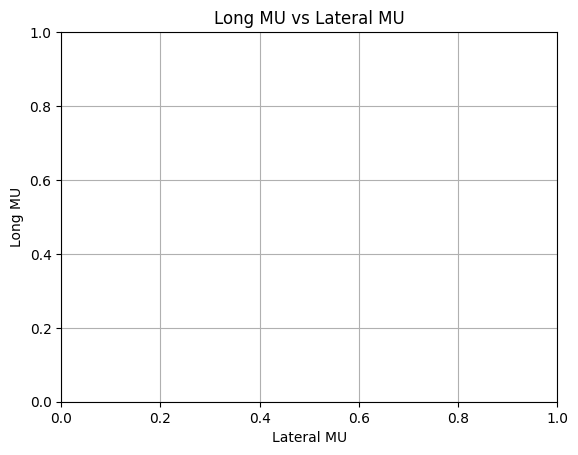

In [53]:
for name,data in tire_coeffs.items():
    if len(data["initial_default"]["lateral_mus"]) > 0 and len(data["initial_default"]["long_mus"]) > 0 :
        la_mu = data["initial_default"]["lateral_mus"][:3] + [data["initial_default"]["lateral_mus"][4]]
        lo_mu = data["initial_default"]["long_mus"]
        plt.scatter(la_mu, lo_mu, label = name)
#plt.legend()
plt.xlabel("Lateral MU")
plt.ylabel("Long MU")
plt.title("Long MU vs Lateral MU")
plt.grid()
#print(tire_coeffs)

In [54]:
rear = tire_coeffs["lc10_16x7-5_10x8"]["initial_default"]["lateral_mus"]
front = tire_coeffs["lc10_16x7-5_10x8"]["initial_default"]["lateral_mus"]
print(sum(rear)/sum(rear+front))

rear_1 = tire_coeffs["lc10_16x7-5_10x8"]["initial_default"]["long_mus"]
rear_2 = tire_coeffs["lc10_16x7-5_10x7"]["initial_default"]["long_mus"]
print(['{:.3f}'.format(x) for x in front])
#rear_1[3]/rear_2[3]

0.5
['1.624', '1.667', '1.716', '1.839', '1.754']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


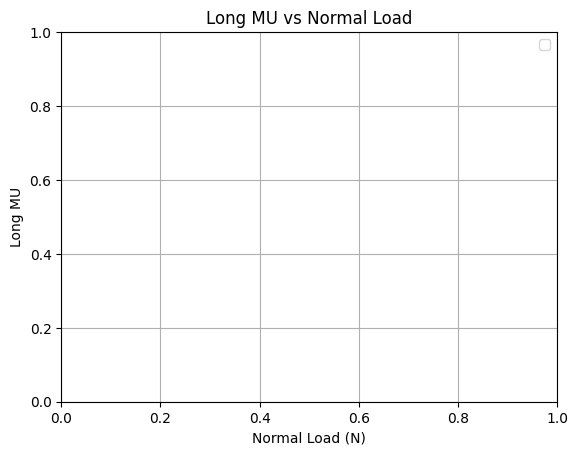

In [55]:
for name,data in tire_coeffs.items():
    if len(data["initial_default"]["long_mus"]) > 0 :
        lo_mu = data["initial_default"]["long_mus"]
        lo_no = data["initial_default"]["long_norms"]
        plt.scatter(lo_no, lo_mu, label = name)
plt.legend()
plt.xlabel("Normal Load (N)")
plt.ylabel("Long MU")
plt.title("Long MU vs Normal Load")
plt.grid()
plt.show()

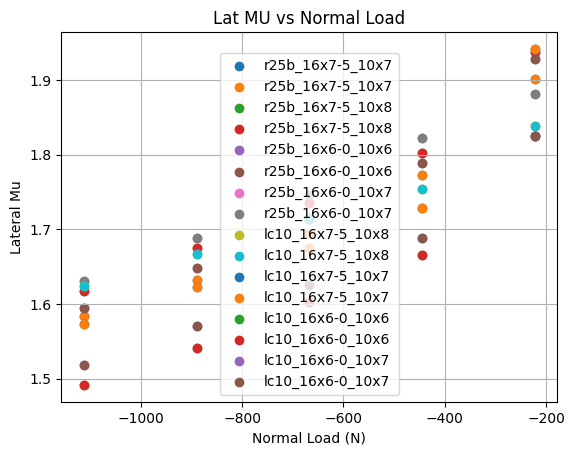

In [56]:
for name,data in tire_coeffs.items():
    if len(data["initial_default"]["lateral_mus"]) > 0 :
        la_mu = data["initial_default"]["lateral_mus"]
        la_no = data["initial_default"]["lat_norms"]
        plt.scatter(la_no, la_mu, label = name)
        # Fit a line to the data points
        # np.polyfit returns the coefficients of the best fit line, [slope, intercept]
        slope, intercept = np.polyfit(la_no, la_mu, 1)
        
        # Generate x values from the min to max of your data for plotting the fit line
        x_fit = np.linspace(min(la_no), max(la_no), 100)
        
        # Calculate the y values based on the slope and intercept
        y_fit = slope * x_fit + intercept
        
        # Plot the best fit line
        plt.scatter(la_no, la_mu, label = name)
plt.legend()
plt.xlabel("Normal Load (N)")
plt.ylabel("Lateral Mu")
plt.title("Lat MU vs Normal Load")
plt.grid()
plt.show()